In [1]:
# Suppress Warnings
import warnings  
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

# Core Libraries
import os
import io
import numpy as np
import pandas as pd

# Image Processing & File Handling
from PIL import Image
from glob import glob

# Data Visualization
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning & Deep Learning
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, BatchNormalization, Dropout, Dense, MaxPool2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Scikit-learn (for data splitting & evaluation)
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Display Utilities (for Jupyter Notebooks)
from IPython.display import display
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [55]:
def prepare_for_train_test(X, Y, test_size=0.2):
    # Split the dataset
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=1)

    # Normalize pixel values (scale between 0 and 1)
    X_train = X_train.astype("float32") / 255.0
    X_test = X_test.astype("float32") / 255.0

    # Convert labels to 1D if needed
    Y_train = Y_train.flatten()
    Y_test = Y_test.flatten()

    return X_train, X_test, Y_train, Y_test

In [56]:
def create_model():
    model = Sequential()
    model.add(Conv2D(16, kernel_size=(3,3), input_shape=(28, 28, 3), activation='relu', padding='same'))
    model.add(MaxPool2D(pool_size=(2,2)))  # Removed invalid padding

    model.add(Conv2D(32, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(MaxPool2D(pool_size=(2,2)))  # Removed invalid padding

    model.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(MaxPool2D(pool_size=(2,2)))  # Removed invalid padding

    model.add(Conv2D(128, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(MaxPool2D(pool_size=(2,2)))  # Removed invalid padding

    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(7, activation='softmax'))  # Assuming 7 classes

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    
    model.summary()  # Prints the model structure
    return model

In [57]:
def train_model(model, X_train, Y_train, EPOCHS=25):
    early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
    
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='min')

    history = model.fit(X_train,
                        Y_train,
                        validation_split=0.2,  # Ensure you haven't pre-split data
                        batch_size=64,
                        epochs=EPOCHS,
                        shuffle=True,  # Ensures better training stability
                        callbacks=[reduce_lr, early_stop])
    
    return history

In [58]:
def test_model(model, X_test, Y_test):
    model_acc = model.evaluate(X_test, Y_test, verbose=0)[1]
    print("Test Accuracy: {:.3f}%".format(model_acc * 100))
    y_true = np.array(Y_test)
    y_pred = model.predict(X_test)
    y_pred = np.array(list(map(lambda x: np.argmax(x), y_pred)))
    clr = classification_report(y_true, y_pred, target_names=label_mapping.values())
    print(clr)
    
    sample_data = X_test[:15]
    plt.figure(figsize=(22, 12))
    for i in range(15):
        plt.subplot(3, 5, i + 1)
        plt.imshow(sample_data[i])
        plt.title(label_mapping[y_true[i][0]] + '|' + label_mapping[y_pred[i]])
        plt.axis("off")
    plt.show() 

In [59]:
def plot_model_training_curve(history):
    fig = make_subplots(rows=1, cols=2, subplot_titles=['Model Accuracy', 'Model Loss'])
    
    fig.add_trace(
        go.Scatter(
            y=history.history.get('accuracy', []), 
            name='train_acc'),
        row=1, col=1)
    
    fig.add_trace(
        go.Scatter(
            y=history.history.get('val_accuracy', []), 
            name='val_acc'),
        row=1, col=1)
    
    fig.add_trace(
        go.Scatter(
            y=history.history.get('loss', []), 
            name='train_loss'),
        row=1, col=2)
    
    fig.add_trace(
        go.Scatter(
            y=history.history.get('val_loss', []), 
            name='val_loss'),
        row=1, col=2)

    # Adding axis labels
    fig.update_xaxes(title_text='Epochs', row=1, col=1)
    fig.update_xaxes(title_text='Epochs', row=1, col=2)
    fig.update_yaxes(title_text='Accuracy', row=1, col=1)
    fig.update_yaxes(title_text='Loss', row=1, col=2)

    fig.show()


In [60]:
def create_confusion_matrix(model, x_test_normalized, y_test, cm_plot_labels, name):
    # Get the predicted and true labels
    y_pred_probs = model.predict(x_test_normalized)
    y_predict_classes = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class indices
    y_true_classes = np.array(y_test)  # Ensure y_test is a NumPy array

    # Compute the confusion matrix
    confusion_matrix_computed = confusion_matrix(y_true_classes, y_predict_classes)

    # Plot the confusion matrix (Ensure this function exists)
    plot_confusion_matrix(confusion_matrix_computed, cm_plot_labels, name)


In [61]:
def plot_confusion_matrix(cm, classes,
                          name,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
    
    plt.figure(figsize=(8,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(name)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Normalize if required
    if normalize:
        cm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-9)  # Avoid division by zero

    # Add text annotations
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i, j]:.2f}" if normalize else f"{int(cm[i, j])}",
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    # Adjust limits to avoid cutoff
    plt.ylim(len(classes) - 0.5, -0.5)  # Fix y-axis label cutoff

    plt.tight_layout()
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    plt.show()  # Ensure the plot is displayed

In [62]:
import os
from glob import glob

# Define the correct base directory (Kaggle or local)
base_skin_dir = "/kaggle/input/skin-cancer-mnist-ham10000"

# Merging images from both folders HAM10000_images_part_1 & HAM10000_images_part_2
image_paths = glob(os.path.join(base_skin_dir, "HAM10000_images_part_1", "*.jpg")) + \
              glob(os.path.join(base_skin_dir, "HAM10000_images_part_2", "*.jpg"))

# Remove duplicates (some images exist in both folders)
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in image_paths}

# Check if images are loaded correctly
print(f"Total unique images found: {len(imageid_path_dict)}")
print("Sample paths:", list(imageid_path_dict.items())[:5])  # Show first 5 image mappings

# Mapping lesion types to their full names
lesion_type_dict = {
    'nv': 'Melanocytic nevi (nv)',
    'mel': 'Melanoma (mel)',
    'bkl': 'Benign keratosis-like lesions (bkl)',
    'bcc': 'Basal cell carcinoma (bcc)',
    'akiec': 'Actinic keratoses (akiec)',
    'vasc': 'Vascular lesions (vasc)',
    'df': 'Dermatofibroma (df)'
}

# Mapping numerical labels to lesion types
label_mapping = {
    0: 'nv',
    1: 'mel',
    2: 'bkl',
    3: 'bcc',
    4: 'akiec',
    5: 'vasc',
    6: 'df'
}

# Reverse mapping lesion type to numerical label
reverse_label_mapping = {v: k for k, v in label_mapping.items()}

# Print mappings for verification
print(label_mapping)
print(reverse_label_mapping)
print(lesion_type_dict)

Total unique images found: 10015
Sample paths: [('ISIC_0028933', '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0028933.jpg'), ('ISIC_0028394', '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0028394.jpg'), ('ISIC_0027799', '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0027799.jpg'), ('ISIC_0028100', '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0028100.jpg'), ('ISIC_0027960', '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0027960.jpg')]
{0: 'nv', 1: 'mel', 2: 'bkl', 3: 'bcc', 4: 'akiec', 5: 'vasc', 6: 'df'}
{'nv': 0, 'mel': 1, 'bkl': 2, 'bcc': 3, 'akiec': 4, 'vasc': 5, 'df': 6}
{'nv': 'Melanocytic nevi (nv)', 'mel': 'Melanoma (mel)', 'bkl': 'Benign keratosis-like lesions (bkl)', 'bcc': 'Basal cell carcinoma (bcc)', 'akiec': 'Actinic keratoses (akiec)', 'vasc': 'Vascular lesions (vasc)', 'df': 'Dermatofibroma (df)'}


In [63]:
import pandas as pd
import os

# Define the base directory
base_skin_dir = "/kaggle/input/skin-cancer-mnist-ham10000"

# Correct file path usage
metadata_path = os.path.join(base_skin_dir, "HAM10000_metadata.csv")

# Load CSV
data = pd.read_csv(metadata_path)


In [64]:
# Now lets see the sample of tile_df to look on newly made columns
data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [65]:
data.describe(exclude=[np.number])

,lesion_id,image_id,dx,dx_type,sex,localization
count,10015,10015,10015,10015,10015,10015
unique,7470,10015,7,4,3,15
top,HAM_0003789,ISIC_0032258,nv,histo,male,back
freq,6,1,6705,5340,5406,2192


In [66]:
data.isnull().any().sum()

1

In [67]:
# Handling null values
data['age'].fillna(value=int(data['age'].mean()), inplace=True)
# Converting dtype of age to int32
data['age'] = data['age'].astype('int32')

In [68]:
# Adding cell_type and image_path columns
data['cell_type'] = data['dx'].map(lesion_type_dict.get)
data['path'] = data['image_id'].map(imageid_path_dict.get)

# Check if there are any missing paths
missing_paths = data[data['path'].isna()]
print(f"Missing image paths: {len(missing_paths)}")

# Check if the mappings look correct
print(data[['image_id', 'path', 'cell_type']].head())


Missing image paths: 0
       image_id                                               path  \
0  ISIC_0027419  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...   
1  ISIC_0025030  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...   
2  ISIC_0026769  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...   
3  ISIC_0025661  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...   
4  ISIC_0031633  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...   

                             cell_type  
0  Benign keratosis-like lesions (bkl)  
1  Benign keratosis-like lesions (bkl)  
2  Benign keratosis-like lesions (bkl)  
3  Benign keratosis-like lesions (bkl)  
4  Benign keratosis-like lesions (bkl)  


In [69]:
data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,path
0,HAM_0000118,ISIC_0027419,bkl,histo,80,male,scalp,Benign keratosis-like lesions (bkl),/kaggle/input/skin-cancer-mnist-ham10000/HAM10...
1,HAM_0000118,ISIC_0025030,bkl,histo,80,male,scalp,Benign keratosis-like lesions (bkl),/kaggle/input/skin-cancer-mnist-ham10000/HAM10...
2,HAM_0002730,ISIC_0026769,bkl,histo,80,male,scalp,Benign keratosis-like lesions (bkl),/kaggle/input/skin-cancer-mnist-ham10000/HAM10...
3,HAM_0002730,ISIC_0025661,bkl,histo,80,male,scalp,Benign keratosis-like lesions (bkl),/kaggle/input/skin-cancer-mnist-ham10000/HAM10...
4,HAM_0001466,ISIC_0031633,bkl,histo,75,male,ear,Benign keratosis-like lesions (bkl),/kaggle/input/skin-cancer-mnist-ham10000/HAM10...


In [70]:
# Ensure valid paths before opening images
def load_image_pixels(path):
    if isinstance(path, str) and os.path.exists(path):  # Check if path is valid
        return np.asarray(Image.open(path).resize((28, 28)))
    else:
        return np.nan  # Use NaN for missing or invalid paths

data['image_pixel'] = data['path'].map(load_image_pixels)

# Check if any images failed to load
missing_images = data[data['image_pixel'].isna()]
print(f"Missing images: {len(missing_images)}")

Missing images: 0


In [71]:
data.head(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,path,image_pixel
0,HAM_0000118,ISIC_0027419,bkl,histo,80,male,scalp,Benign keratosis-like lesions (bkl),/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,"[[[192, 153, 193], [195, 155, 192], [197, 154,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80,male,scalp,Benign keratosis-like lesions (bkl),/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,"[[[27, 16, 32], [69, 49, 76], [122, 93, 126], ..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80,male,scalp,Benign keratosis-like lesions (bkl),/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,"[[[192, 138, 153], [200, 144, 162], [202, 142,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80,male,scalp,Benign keratosis-like lesions (bkl),/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,"[[[40, 21, 31], [95, 61, 73], [143, 102, 118],..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75,male,ear,Benign keratosis-like lesions (bkl),/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,"[[[159, 114, 140], [194, 144, 173], [215, 162,..."


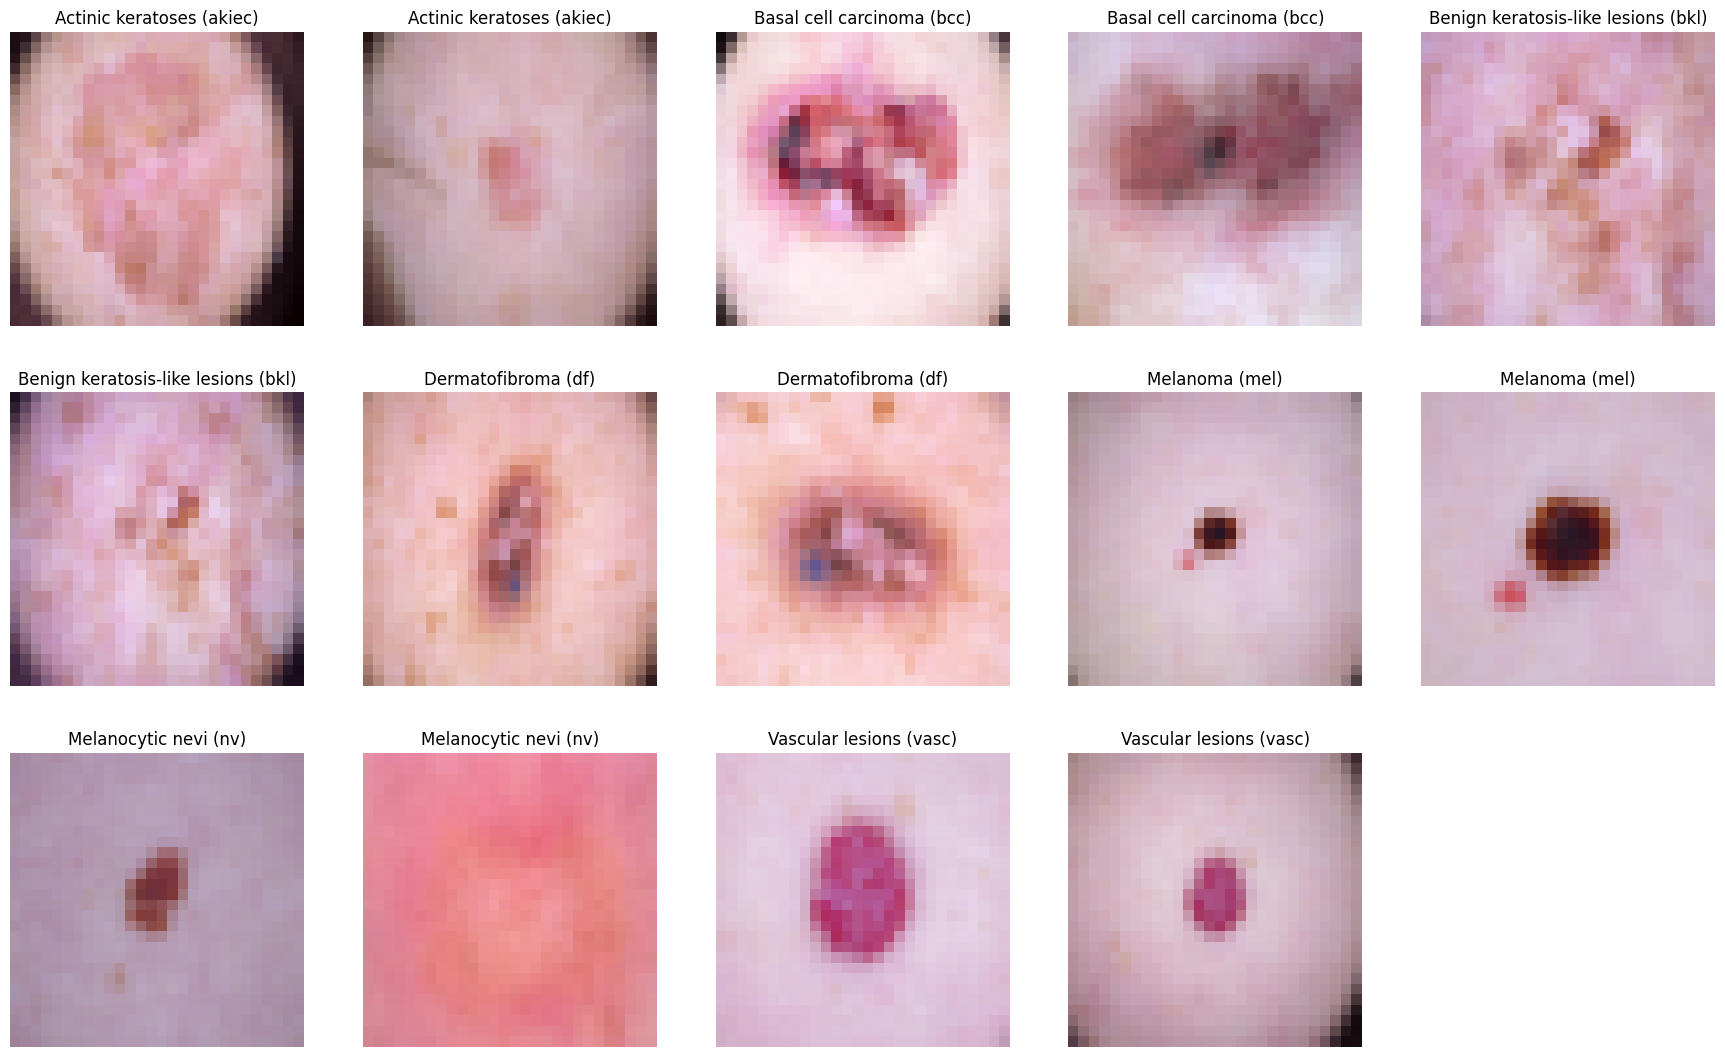

In [72]:
# Displaying 2 images for each label
sample_data = data.groupby('dx').apply(lambda df: df.iloc[:2, [9, 7]])
plt.figure(figsize=(22, 32))
for i in range(14):
    plt.subplot(7, 5, i + 1)
    plt.imshow(np.squeeze(sample_data['image_pixel'][i]))
    img_label = sample_data['cell_type'][i]
    plt.title(img_label)
    plt.axis("off")
plt.show();

In [73]:
# Map dx to numerical labels
data['label'] = data['dx'].map(reverse_label_mapping.get)

# Handle any missing values in 'label' (optional, depending on dataset)
data = data.dropna(subset=['label'])

# Convert 'label' to int (if needed)
data['label'] = data['label'].astype(int)

# Sort by label and reset index
data = data.sort_values('label').reset_index(drop=True)

In [74]:
counter = 0
frames = [data]

for i in [4, 4, 11, 17, 45, 52]:
    counter += 1
    index = data[data['label'] == counter].index.values
    
    if len(index) == 0:  # Ensure index is not empty
        print(f"Warning: No data found for label {counter}")
        continue
    
    df_index = data.iloc[int(min(index)):int(max(index) + 1)]
    
    # Replicate df_index 'i' times
    df_index = pd.concat([df_index] * (i + 1), ignore_index=True)
    
    frames.append(df_index)


In [75]:
len(frames)

7

In [76]:
final_data = pd.concat(frames)

In [77]:
# ORIGINAL DATA
# Converting image pixel columnm into required format
X_orig = data['image_pixel'].to_numpy()
X_orig = np.stack(X_orig, axis=0)
Y_orig = np.array(data.iloc[:, -1:])
print(X_orig.shape)
print(Y_orig.shape)

(10015, 28, 28, 3)
(10015, 1)


In [78]:
# AUGMENTED DATA
# Converting image pixel columnm into required format
X_aug = final_data['image_pixel'].to_numpy()
X_aug = np.stack(X_aug, axis=0)
Y_aug = np.array(final_data.iloc[:, -1:])
print(X_aug.shape)
print(Y_aug.shape)

(45756, 28, 28, 3)
(45756, 1)


In [79]:
X_train_orig, X_test_orig, Y_train_orig, Y_test_orig = prepare_for_train_test(X_orig, Y_orig)

In [80]:
model =create_model()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 28, 28, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 14, 14, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 14, 14, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 7, 7, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 7, 7, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 3, 3, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 3, 3, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 1, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 7)                   │             231 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 108,007 (421.90 KB)

 Trainable params: 108,007 (421.90 KB)

 Non-trainable params: 0 (0.00 B)

In [81]:
X_train_aug, X_test_aug, Y_train_aug, Y_test_aug = prepare_for_train_test(X_aug, Y_aug)

In [82]:
model2_history = train_model(model, X_train_aug, Y_train_aug, 50)

Epoch 1/50
458/458 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.3069 - loss: 1.6726 - val_accuracy: 0.5551 - val_loss: 1.1401 - learning_rate: 0.0010
Epoch 2/50
458/458 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5673 - loss: 1.0978 - val_accuracy: 0.6550 - val_loss: 0.8959 - learning_rate: 0.0010
Epoch 3/50
458/458 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6574 - loss: 0.8774 - val_accuracy: 0.7081 - val_loss: 0.7586 - learning_rate: 0.0010
Epoch 4/50
458/458 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7356 - loss: 0.6961 - val_accuracy: 0.7850 - val_loss: 0.5877 - learning_rate: 0.0010
Epoch 5/50
458/458 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7915 - loss: 0.5437 - val_accuracy: 0.8298 - val_loss: 0.4721 - learning_rate: 0.0010
Epoch 6/50
458/458 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8330 - loss: 0.4436 - val_accuracy: 0.8593 - val_loss: 0.3838 - learning_rate: 0.0010
Epoch 7/50
458/458 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8623 - loss: 0.3673 -

In [83]:
model

<Sequential name=sequential_1, built=True>

In [85]:
print(model2_history.history.keys())  

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])


Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Accuracy')

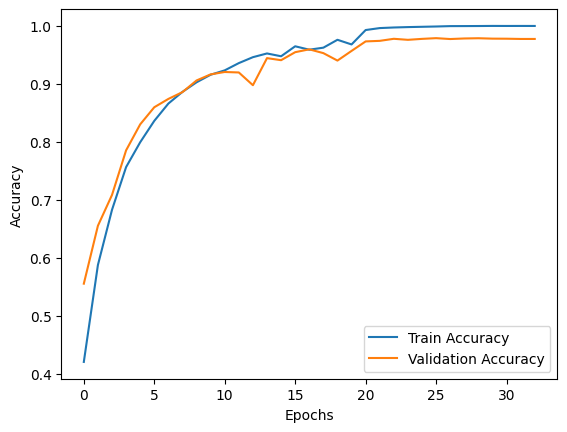

In [88]:
import matplotlib.pyplot as plt

plt.plot(model2_history.history['accuracy'], label='Train Accuracy')
plt.plot(model2_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9640 - loss: 0.1574
Test Accuracy: 97.054%
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
              precision    recall  f1-score   support

          nv       1.00      0.96      0.98      1374
         mel       0.88      0.99      0.93       205
         bkl       0.92      1.00      0.96       227
         bcc       0.97      1.00      0.98        94
       akiec       1.00      1.00      1.00        55
        vasc       0.78      1.00      0.88        28
          df       1.00      1.00      1.00        20

    accuracy                           0.97      2003
   macro avg       0.94      0.99      0.96      2003
weighted avg       0.97      0.97      0.97      2003

X_test shape: (2003, 28, 28, 3)
Y_test shape: (2003,)
First 10 Y_test: [0 0 2 0 0 0 0 1 0 0]
First 10 y_pred: [0 2 2 0 0 0 0 1 0 0]


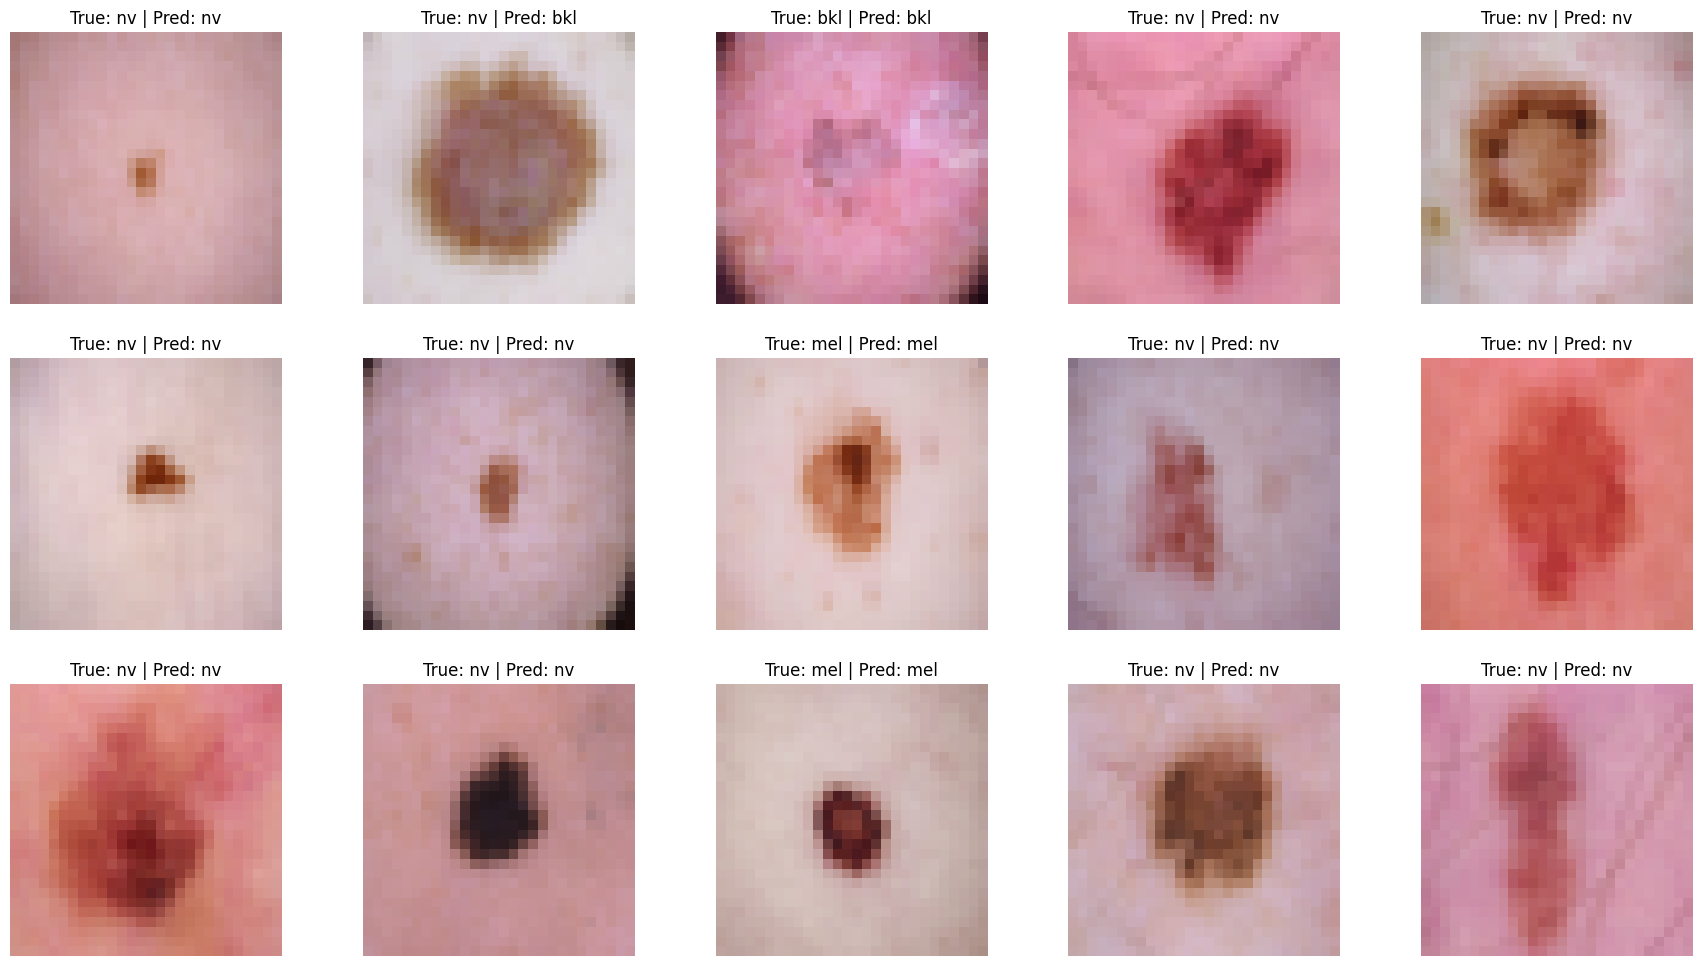

Plot saved as 'output.png'. Check if it exists.


<Figure size 640x480 with 0 Axes>

In [93]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

def test_model(model, X_test, Y_test):
    # Evaluate model accuracy
    model_acc = model.evaluate(X_test, Y_test, verbose=1)[1]
    print("Test Accuracy: {:.3f}%".format(model_acc * 100))

    # Ensure Y_test is 1D
    y_true = np.array(Y_test).flatten()

    # Get model predictions
    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis=1)

    # Print classification report
    clr = classification_report(y_true, y_pred, target_names=label_mapping.values())
    print(clr)

    # Debugging prints
    print(f"X_test shape: {X_test.shape}")
    print(f"Y_test shape: {Y_test.shape}")
    print(f"First 10 Y_test: {y_true[:10]}")
    print(f"First 10 y_pred: {y_pred[:10]}")

    # Display 15 sample images
    plt.figure(figsize=(22, 12))
    for i in range(min(15, len(X_test))):  # Prevent errors if fewer than 15 samples
        plt.subplot(3, 5, i + 1)
        plt.imshow(X_test[i])
        plt.title(f"True: {label_mapping[y_true[i]]} | Pred: {label_mapping[y_pred[i]]}")
        plt.axis("off")

    # Ensure plot displays
    plt.show(block=True)

    # Save image in case display fails
    plt.savefig("output.png")
    print("Plot saved as 'output.png'. Check if it exists.")

test_model(model, X_test_orig, Y_test_orig)


In [94]:
data.head()
data.iloc[2]

,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,path,image_pixel,label
0,HAM_0005936,ISIC_0024921,nv,follow_up,60,male,trunk,Melanocytic nevi (nv),/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,"[[[228, 141, 166], [226, 134, 159], [223, 129,...",0
1,HAM_0000115,ISIC_0030745,nv,follow_up,75,male,back,Melanocytic nevi (nv),/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,"[[[245, 155, 163], [245, 153, 159], [244, 150,...",0
2,HAM_0002830,ISIC_0025796,nv,follow_up,75,male,abdomen,Melanocytic nevi (nv),/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,"[[[238, 145, 160], [236, 139, 158], [239, 144,...",0
3,HAM_0006305,ISIC_0031274,nv,follow_up,75,male,abdomen,Melanocytic nevi (nv),/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,"[[[233, 137, 153], [234, 139, 152], [236, 140,...",0
4,HAM_0005592,ISIC_0026077,nv,follow_up,50,male,foot,Melanocytic nevi (nv),/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,"[[[241, 150, 176], [244, 155, 179], [245, 161,...",0


lesion_id                                             HAM_0002830
image_id                                             ISIC_0025796
dx                                                             nv
dx_type                                                 follow_up
age                                                            75
sex                                                          male
localization                                              abdomen
cell_type                                   Melanocytic nevi (nv)
path            /kaggle/input/skin-cancer-mnist-ham10000/HAM10...
image_pixel     [[[238, 145, 160], [236, 139, 158], [239, 144,...
label                                                           0
Name: 2, dtype: object

In [95]:
one_picture_predict_data = data.iloc[2]
print(one_picture_predict_data)
print(one_picture_predict_data.dx)
#print(one_picture_predict_data.image_pixel)
y_value = reverse_label_mapping.get(one_picture_predict_data.dx)
print(y_value)


one_picture_predict_data.image_pixel.shape
new_one = one_picture_predict_data.image_pixel.reshape((1,28,28,3))
model.predict(new_one)

lesion_id                                             HAM_0002830
image_id                                             ISIC_0025796
dx                                                             nv
dx_type                                                 follow_up
age                                                            75
sex                                                          male
localization                                              abdomen
cell_type                                   Melanocytic nevi (nv)
path            /kaggle/input/skin-cancer-mnist-ham10000/HAM10...
image_pixel     [[[238, 145, 160], [236, 139, 158], [239, 144,...
label                                                           0
Name: 2, dtype: object
nv
0


(28, 28, 3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step


array([[1., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [96]:
print(data.iloc[2].path)
im = np.asarray(Image.open(data.iloc[2].path))
im.shape
im = im.reshape((1,450,600,3))
im.shape
new_one = one_picture_predict_data.image_pixel.reshape((1,28,28,3))
model.predict(new_one)

/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0025796.jpg


(450, 600, 3)

(1, 450, 600, 3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


array([[1., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [97]:
model.save('skin_cancer_prediction.h5')